In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# Response: Combine Rental and Housing Prices from 2011 and 2015

First we take rental data (median price per square foot of every zip code in America that we can find) from Zillow and clean it up by calculating the mean across 2011 and 2015 and adjusting the 2015 price for inflation.

In [36]:
rental_raw = pd.read_csv('data/Zip_ZriPerSqft_AllHomes.csv')
rental_raw.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,62080,11368,New York,NY,New York,Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.868,1.894,1.914,1.948,1.962,1.968,1.962,1.970,1.962,1.942,1.942,1.982,2.000,1.998,1.998,1.994,2.006,2.030,2.066,2.088,2.096,2.094,2.082,2.110,2.116,2.126,2.134,2.146,2.168,2.194,2.204,2.218,2.230,2.264,2.282,2.316,2.304,2.298,2.306,2.310,2.306,2.290,2.284,2.280,2.312,2.354,2.404
1,93144,79936,El Paso,TX,El Paso,El Paso,2,0.760,0.760,0.756,0.750,0.746,0.740,0.742,0.744,0.742,0.740,0.742,0.742,0.742,0.744,0.748,0.754,0.756,0.756,0.756,0.756,0.754,0.750,0.746,0.744,0.738,0.734,0.730,0.726,0.722,0.722,0.720,0.720,0.722,0.724,0.726,0.726,0.724,0.724,0.724,0.726,0.726,0.728,0.726,0.724,0.722,0.722,0.722,0.724,0.722,0.724,0.726,0.730,0.732,0.736,0.736,0.738,0.740,0.742,0.742,0.742
2,84630,60629,Chicago,IL,Chicago,Cook,3,1.194,1.212,1.222,1.226,1.224,1.226,1.220,1.208,1.194,1.190,1.182,1.168,1.160,1.144,1.140,1.142,1.144,1.136,1.140,1.144,1.152,1.144,1.136,1.138,1.158,1.162,1.156,1.158,1.160,1.172,1.178,1.188,1.190,1.194,1.192,1.202,1.226,1.234,1.240,1.238,1.238,1.232,1.232,1.232,1.236,1.240,1.252,1.256,1.266,1.254,1.246,1.238,1.238,1.240,1.238,1.240,1.244,1.254,1.258,1.258
3,96193,90650,Norwalk,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,4,1.518,1.514,1.514,1.512,1.516,1.518,1.520,1.520,1.522,1.526,1.530,1.536,1.538,1.540,1.542,1.542,1.544,1.542,1.536,1.534,1.536,1.540,1.546,1.544,1.542,1.546,1.554,1.562,1.566,1.574,1.584,1.594,1.598,1.600,1.604,1.610,1.614,1.622,1.620,1.620,1.612,1.612,1.616,1.626,1.632,1.640,1.652,1.666,1.678,1.688,1.700,1.712,1.726,1.742,1.750,1.756,1.760,1.764,1.766,1.766
4,62037,11226,New York,NY,New York,Kings,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.014,1.006,1.008,1.010,1.010,1.014,1.032,1.046,1.064,1.070,1.070,1.094,1.096,1.110,1.118,1.120,1.124,1.138,1.146,1.156,1.156,1.168,1.180,1.224,1.246,1.266,1.276,1.290,1.310,1.324,1.334,1.346,1.358,1.358,1.344,1.348,1.338,1.330,1.336,1.348,1.352,1.348,1.342,1.344,1.354,1.374,1.398


In [37]:
col_11 = [col for col in rental_raw.columns if '2011' in col]
col_14_15 = rental_raw.columns[-12:]
rental_raw['agg_2011'] = rental_raw[col_11].mean(axis=1)
rental_raw['agg_2015'] = rental_raw[col_14_15].mean(axis=1)
rental_raw = rental_raw[['RegionName','agg_2011','agg_2015']]

infl_rate = 1.0573
rental_raw['agg_2015_adj'] = rental_raw.agg_2015/infl_rate
rental_raw['pct_delta'] = rental_raw.agg_2015_adj/rental_raw.agg_2011

In [38]:
houses = pd.read_pickle('data/response_houses.pkl')
houses.columns = ['h_'+str(column) if column != 'RegionName' else column for column in houses.columns]
rental = pd.read_pickle('data/response_rental.pkl')
rental.columns = ['r_'+str(column) if column != 'RegionName' else column for column in rental.columns]

In [41]:
rental_raw.drop('agg_2015',1).to_pickle('data/response_rental.pkl')
print rental_raw.shape
rental_raw.head()

(14925, 5)


,RegionName,agg_2011,agg_2015,agg_2015_adj,pct_delta
0,11368,1.868000,2.313667,2.188278,1.171455
1,79936,0.744167,0.734167,0.694379,0.933096
2,60629,1.197000,1.247833,1.180207,0.985971
3,90650,1.524333,1.734000,1.640026,1.075898
4,11226,1.014000,1.351000,1.277783,1.260141


We do the same workflow for median housing price per square foot. 

In [42]:
sold = pd.read_csv('data/Zip_MedianValuePerSqft_AllHomes.csv')
sold.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,...,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,62080,11368,New York,NY,New York,Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,377,374,372,369,367,368,370,369,367,366,367,366,367,368,369,371,372,372,370,368,366,366,370,374,381,387,395,399,402,407,411,417,424,430,435,445,452,457,458,457,457,458,460,462,465,467,466,464,468,474
1,93144,79936,El Paso,TX,El Paso,El Paso,2,50,51,50,50,50,50,51,51,52,52,52,52,52,52,53,53,53,53,54,54,55,55,55,55,55,54,54,54,54,54,54,54,53,54,54,54,54,54,55,55,55,56,56,...,80,80,79,79,79,79,80,80,79,79,79,78,79,79,78,78,78,78,79,79,79,79,79,80,80,80,79,80,80,81,80,80,79,79,79,80,80,80,80,79,79,79,79,79,79,79,79,80,80,80
2,84630,60629,Chicago,IL,Chicago,Cook,3,83,83,83,83,84,84,84,83,84,84,84,84,84,84,84,84,84,84,84,84,85,85,86,87,87,87,87,87,87,88,89,90,90,90,91,91,92,93,93,93,94,95,96,...,103,102,102,101,99,98,97,96,96,97,98,98,98,98,99,99,100,101,104,106,109,111,112,113,113,114,116,116,117,117,117,118,119,119,119,119,119,120,120,120,120,120,120,119,119,120,122,124,124,124
3,96193,90650,Norwalk,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,4,116,116,116,115,114,114,114,115,115,115,116,116,116,116,116,116,115,115,116,116,117,118,119,119,120,120,121,122,122,123,124,125,125,125,125,125,125,126,126,127,128,129,129,...,226,224,224,224,225,225,226,227,228,230,232,233,235,235,236,238,240,244,248,254,259,264,269,274,278,282,285,288,291,293,295,298,300,302,303,304,304,305,306,307,308,311,314,316,317,318,320,323,324,325
4,62037,11226,New York,NY,New York,Kings,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,306,305,304,302,300,301,301,300,301,302,302,303,305,307,311,317,321,324,324,325,326,328,332,340,348,353,359,364,365,365,375,393,409,418,425,432,439,444,446,447,448,448,448,447,448,451,456,461,463,463


In [43]:
col_11 = [col for col in sold.columns if '2011' in col]
sold['agg_2011'] = sold[col_11].mean(axis=1)

In [44]:
col_14_15 = sold.columns[-12:]
sold['agg_2015'] = sold[col_14_15].mean(axis=1)
sold['agg_2015_adj'] = [index/1.0573 for index in sold['agg_2015']]
sold['pct_delta'] = sold['agg_2015_adj'] / sold['agg_2011']

In [46]:
sold = sold[['RegionName','agg_2011','agg_2015_adj','pct_delta']]
sold.to_pickle('data/response_houses.pkl')
print sold.shape
sold.head()

(13004, 4)


,RegionName,agg_2011,agg_2015_adj,pct_delta
0,11368,373.833333,431.274105,1.153653
1,79936,80.333333,75.060164,0.934359
2,60629,107.166667,113.430961,1.058454
3,90650,228.750000,292.549418,1.278905
4,11226,309.166667,416.876846,1.348389


Now we combine the two files by merging on zipcode, and dropping all rows with na's.

In [47]:
rental = pd.read_pickle('data/response_rental.pkl')
rental.columns = ['r_' + column if column != 'RegionName' else column for column in rental.columns]
houses = pd.read_pickle('data/response_houses.pkl')
houses.columns = ['h_' + column if column != 'RegionName' else column for column in houses.columns]

In [52]:
df = rental.merge(houses, on='RegionName')
print df.shape
df.head()

(11892, 7)


,RegionName,r_agg_2011,r_agg_2015_adj,r_pct_delta,h_agg_2011,h_agg_2015_adj,h_pct_delta
0,11368,1.868000,2.188278,1.171455,373.833333,431.274105,1.153653
1,79936,0.744167,0.694379,0.933096,80.333333,75.060164,0.934359
2,60629,1.197000,1.180207,0.985971,107.166667,113.430961,1.058454
3,90650,1.524333,1.640026,1.075898,228.750000,292.549418,1.278905
4,11226,1.014000,1.277783,1.260141,309.166667,416.876846,1.348389


In [56]:
df['ratio_2011'] = df['h_agg_2011'] / df['r_agg_2011'] / 12.
df['ratio_2015'] = df['h_agg_2015_adj'] / df['r_agg_2015_adj'] / 12.
df['ratio_pct_delta'] = df['ratio_2015'] / df['ratio_2011']
df.head()

,RegionName,r_agg_2011,r_agg_2015_adj,r_pct_delta,h_agg_2011,h_agg_2015_adj,h_pct_delta,ratio_2011,ratio_2015,ratio_pct_delta
0,11368,1.868000,2.188278,1.171455,373.833333,431.274105,1.153653,16.677076,16.423646,0.984804
1,79936,0.744167,0.694379,0.933096,80.333333,75.060164,0.934359,8.995894,9.008072,1.001354
2,60629,1.197000,1.180207,0.985971,107.166667,113.430961,1.058454,7.460782,8.009253,1.073514
3,90650,1.524333,1.640026,1.075898,228.750000,292.549418,1.278905,12.505467,14.865076,1.188686
4,11226,1.014000,1.277783,1.260141,309.166667,416.876846,1.348389,25.408174,27.187509,1.070030


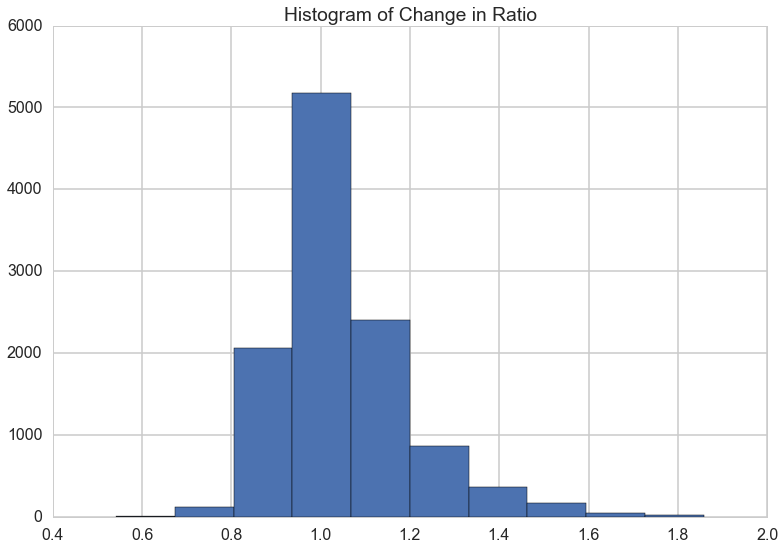

In [57]:
plt.hist(df['ratio_pct_delta'].dropna().tolist());
plt.title('Histogram of Change in Ratio');

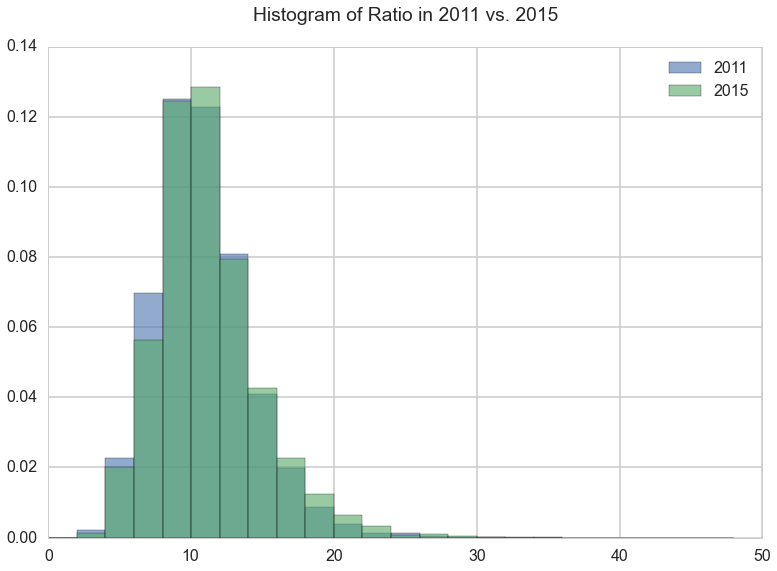

In [60]:
setbins = range(0,50,2)
plt.hist(df['ratio_2011'].dropna().tolist(), bins = setbins, normed=True, alpha=0.6, label='2011');
plt.hist(df['ratio_2015'].dropna().tolist(), bins = setbins, normed=True, alpha=0.6, label='2015');
plt.title('Histogram of Ratio in 2011 vs. 2015\n');
plt.legend();

In [61]:
df.to_pickle('data/housing_rental_ratio.pkl')

# Response: Housing Prices Only

We didn't end up using this as our response variable (we ran some models with it in the beginning and found our predictive power to be rather low, so we abandoned it), but we found the median housing prices per sq foot for American Zip Codes in 2000, and 2010, and calculated the inflation adjusted change.

In [20]:
zip_MVPS = pd.read_csv('Data/Zip_MedianValuePerSqft_AllHomes.csv')
zip_MVPS.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,...,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,62080,11368,New York,NY,New York,Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,377,374,372,369,367,368,370,369,367,366,367,366,367,368,369,371,372,372,370,368,366,366,370,374,381,387,395,399,402,407,411,417,424,430,435,445,452,457,458,457,457,458,460,462,465,467,466,464,468,474
1,93144,79936,El Paso,TX,El Paso,El Paso,2,50,51,50,50,50,50,51,51,52,52,52,52,52,52,53,53,53,53,54,54,55,55,55,55,55,54,54,54,54,54,54,54,53,54,54,54,54,54,55,55,55,56,56,...,80,80,79,79,79,79,80,80,79,79,79,78,79,79,78,78,78,78,79,79,79,79,79,80,80,80,79,80,80,81,80,80,79,79,79,80,80,80,80,79,79,79,79,79,79,79,79,80,80,80
2,84630,60629,Chicago,IL,Chicago,Cook,3,83,83,83,83,84,84,84,83,84,84,84,84,84,84,84,84,84,84,84,84,85,85,86,87,87,87,87,87,87,88,89,90,90,90,91,91,92,93,93,93,94,95,96,...,103,102,102,101,99,98,97,96,96,97,98,98,98,98,99,99,100,101,104,106,109,111,112,113,113,114,116,116,117,117,117,118,119,119,119,119,119,120,120,120,120,120,120,119,119,120,122,124,124,124
3,96193,90650,Norwalk,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,4,116,116,116,115,114,114,114,115,115,115,116,116,116,116,116,116,115,115,116,116,117,118,119,119,120,120,121,122,122,123,124,125,125,125,125,125,125,126,126,127,128,129,129,...,226,224,224,224,225,225,226,227,228,230,232,233,235,235,236,238,240,244,248,254,259,264,269,274,278,282,285,288,291,293,295,298,300,302,303,304,304,305,306,307,308,311,314,316,317,318,320,323,324,325
4,62037,11226,New York,NY,New York,Kings,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,306,305,304,302,300,301,301,300,301,302,302,303,305,307,311,317,321,324,324,325,326,328,332,340,348,353,359,364,365,365,375,393,409,418,425,432,439,444,446,447,448,448,448,447,448,451,456,461,463,463


In [21]:
%%capture
#Drop rows that have NAN for those dates
zip_MVPS_notNAN = zip_MVPS.dropna(subset = ['2000-01','2001-01','1999-01','2010-01','2009-01','2011-01'])
#Cast Zipcodes as strings and add 0s to the beginning of the zipcodes if they are less than 5 characters
zip_MVPS_notNAN['RegionName'] = zip_MVPS_notNAN['RegionName'].astype(str)
zip_MVPS_notNAN.RegionName = [(5-len(zipcode))*'0' + zipcode if len(zipcode) < 5 else zipcode for zipcode in zip_MVPS_notNAN.RegionName]
zip_MVPS_notNAN.shape

(11854, 242)

In [76]:
zip_MVPS_notNAN.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,...,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
1,93144,79936,El Paso,TX,El Paso,El Paso,2,50,51,50,50,50,50,51,51,52,52,52,52,52,52,53,53,53,53,54,54,55,55,55,55,55,54,54,54,54,54,54,54,53,54,54,54,54,54,55,55,55,56,56,...,80,80,79,79,79,79,80,80,79,79,79,78,79,79,78,78,78,78,79,79,79,79,79,80,80,80,79,80,80,81,80,80,79,79,79,80,80,80,80,79,79,79,79,79,79,79,79,80,80,80
2,84630,60629,Chicago,IL,Chicago,Cook,3,83,83,83,83,84,84,84,83,84,84,84,84,84,84,84,84,84,84,84,84,85,85,86,87,87,87,87,87,87,88,89,90,90,90,91,91,92,93,93,93,94,95,96,...,103,102,102,101,99,98,97,96,96,97,98,98,98,98,99,99,100,101,104,106,109,111,112,113,113,114,116,116,117,117,117,118,119,119,119,119,119,120,120,120,120,120,120,119,119,120,122,124,124,124
3,96193,90650,Norwalk,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,4,116,116,116,115,114,114,114,115,115,115,116,116,116,116,116,116,115,115,116,116,117,118,119,119,120,120,121,122,122,123,124,125,125,125,125,125,125,126,126,127,128,129,129,...,226,224,224,224,225,225,226,227,228,230,232,233,235,235,236,238,240,244,248,254,259,264,269,274,278,282,285,288,291,293,295,298,300,302,303,304,304,305,306,307,308,311,314,316,317,318,320,323,324,325
7,96083,90201,Bell,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,8,123,123,122,121,120,120,119,119,119,119,120,120,120,120,120,119,119,120,120,120,120,120,121,121,122,122,123,123,124,124,124,125,125,124,124,124,124,125,126,126,126,127,127,...,205,204,205,206,207,208,209,210,210,210,211,212,213,215,215,216,218,222,226,233,238,242,246,250,254,257,260,263,266,268,268,268,268,271,274,278,281,283,285,285,286,288,290,292,294,295,297,299,300,301
8,96125,90280,South Gate,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,9,120,120,120,120,119,120,120,120,120,121,121,120,120,120,120,120,119,119,119,118,118,118,119,120,121,121,121,120,121,121,122,122,123,122,122,122,122,123,124,125,125,126,127,...,204,204,203,203,204,206,207,207,207,208,209,209,210,212,214,216,220,223,226,230,235,240,243,247,251,255,258,261,263,265,266,268,269,270,271,273,275,276,277,278,278,279,283,286,288,290,292,294,296,299


After taking out all of the rows with NaNs, we took the average of January data from 1999, 2000, and 2001 to get the aggregate value of 2000; the average of January data from 2009, 2010, and 2011 to get the aggregate value of 2010.

In [84]:
%%capture
zip_MVPS_notNAN['2000_agg'] = (zip_MVPS_notNAN['2000-01'] + zip_MVPS_notNAN['2001-01'] + zip_MVPS_notNAN['1999-01'])/3
zip_MVPS_notNAN['2010_agg'] = (zip_MVPS_notNAN['2010-01'] + zip_MVPS_notNAN['2011-01'] + zip_MVPS_notNAN['2009-01'])/3
zip_MVPS_notNAN['pct_delta'] = zip_MVPS_notNAN['2010_agg']/zip_MVPS_notNAN['2000_agg']

(0, 1100)

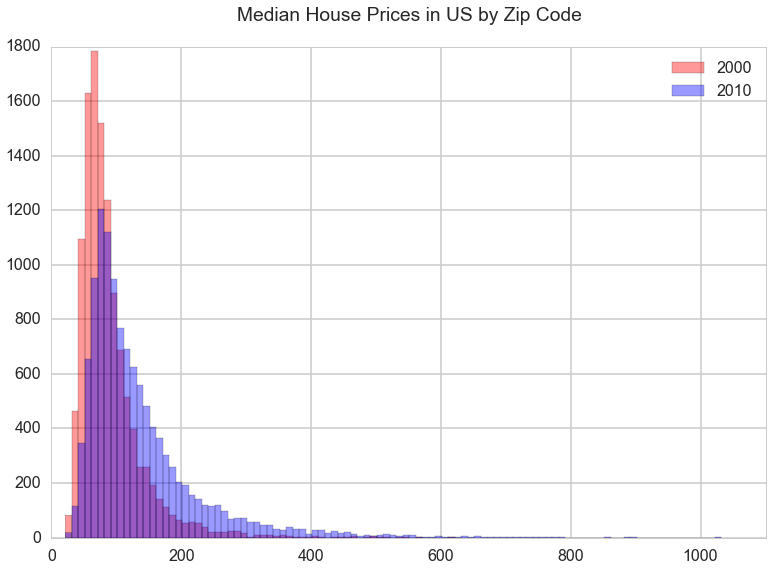

In [87]:
plt.hist(zip_MVPS_notNAN['2000_agg'].values, bins=np.arange(min(zip_MVPS_notNAN['2000_agg'].values), max(zip_MVPS_notNAN['2000_agg'].values) + 10, 10), color = 'r', alpha = 0.4, label = '2000')
plt.hist(zip_MVPS_notNAN['2010_agg'].values, bins=np.arange(min(zip_MVPS_notNAN['2010_agg'].values), max(zip_MVPS_notNAN['2010_agg'].values) + 10, 10), color = 'b', alpha = 0.4, label = '2010')
plt.legend()
plt.title('Median House Prices in US by Zip Code\n')
plt.xlim(0,1100)

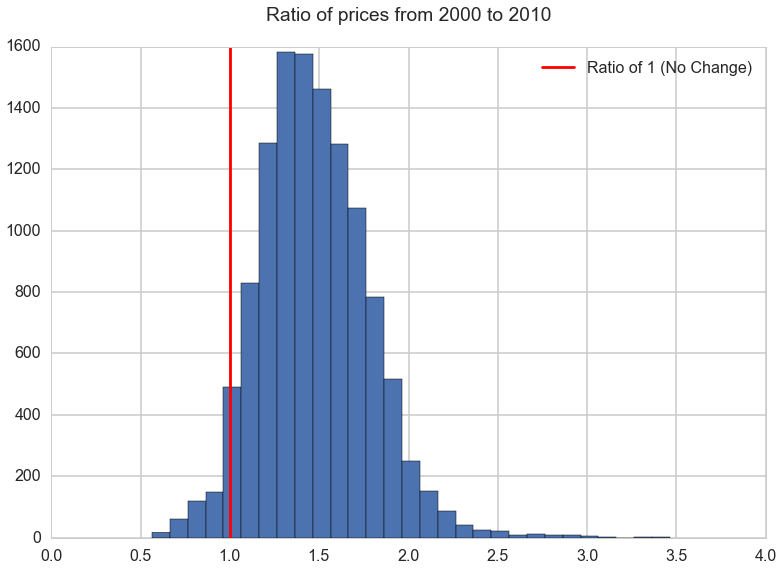

In [96]:
plt.hist(zip_MVPS_notNAN['pct_delta'].values, 
         bins=np.arange(min(zip_MVPS_notNAN['pct_delta'].values), 
                        max(zip_MVPS_notNAN['pct_delta'].values) + .1, .1));
plt.axvline(1, 0, 1, color='r', label='Ratio of 1 (No Change)');
plt.title('Ratio of prices from 2000 to 2010\n');
plt.xlim(0,4);
plt.legend();

In [97]:
zip_MVPS_notNAN.to_pickle('data/ZipcodeMVPSnew.pkl')

# Features: Business Metrics

We felt that an important determinant of housing/rental prices in a region might be business metrics for that region. These include the number of businesses, number of employed persons, first quarter pay, and annual payroll for businesses in that region (zipcode). We took this data from American Fact Finder (which is based off of the US Census). We clean the data so that we have a zipcode associated with each row.

In [19]:
bus_data_raw = pd.read_csv('data/BP_2010_00CZ1_with_ann.csv')
bus_data_raw.head()

,GEO.id,GEO.id2,GEO.display-label,NAICS.id,NAICS.display-label,YEAR.id,ESTAB,EMP,PAYQTR1,PAYANN
0,Geographic identifier code,Id2,Geographic area name,2007 NAICS code,Meaning of 2007 NAICS code,Year,Number of establishments,Paid employees for pay period including March ...,"First-quarter payroll ($1,000)","Annual payroll ($1,000)"
1,8610000US00501,00501,"ZIP 00501 (Holtsville, NY)",00,Total for all sectors,2010,2,a,D,D
2,8610000US01001,01001,"ZIP 01001 (Agawam, MA)",00,Total for all sectors,2010,448,9185,70693,314508
3,8610000US01002,01002,"ZIP 01002 (Amherst, MA)",00,Total for all sectors,2010,570,15633,82069,351589
4,8610000US01003,01003,"ZIP 01003 (Amherst, MA)",00,Total for all sectors,2010,16,168,1297,5761


In [20]:
# rename columns and drop unnecessary columns
bus_data = bus_data_raw.drop(['GEO.id2','NAICS.id','NAICS.display-label', 'YEAR.id'],1)
bus_data.columns = bus_data.iloc[0].values
bus_data = bus_data[bus_data['Geographic identifier code'] != 'Geographic identifier code']
bus_data = bus_data.reset_index(drop=True)

# code from census data that maps letters (in paid employees col) to ints
letter_map = {'a':10, 'D':np.nan, 'b':60, 'c':175, 'h':3750, 'f':750, 'i':7500, 'g':1750, 'S':np.nan, 'e':375, 'j':17500, 'l':75000, 'k':37500, 'm':100000}
# get list of paid employees column for processing
paid_employees_raw = bus_data['Paid employees for pay period including March 12 (number)']

# function to process the paid employees. turn strings to ints, and convert letters to corresponding ints.
def process_employees(el):
    try:
        num = int(el)
    except ValueError:
        num = letter_map[el]
    return num

# get list of paid employees, all values should be ints
paid_employees = [process_employees(el) for el in paid_employees_raw]

# do the same for 'first-quarter payroll' and 'annual payroll', they only have the 'D' value
first_quarter = [process_employees(el) for el in bus_data['First-quarter payroll ($1,000)']]
annual = [process_employees(el) for el in bus_data['Annual payroll ($1,000)']]

# add these to dataframe, delete old columns
bus_data['paid_employees'] = paid_employees
bus_data['first_quarter_payroll_1000'] = first_quarter
bus_data['annual_payroll_1000'] = annual
# get zipcodes from last 5 characters of 'Geographic identifier code'
bus_data['zipcode'] = [el[-5:] for el in bus_data['Geographic identifier code']]
bus_data = bus_data.drop(['Paid employees for pay period including March 12 (number)','First-quarter payroll ($1,000)','Annual payroll ($1,000)','Geographic identifier code'],1)
bus_data = bus_data.dropna(subset = ['annual_payroll_1000', 'first_quarter_payroll_1000'])

In [21]:
bus_data.shape, bus_data_raw.shape

((31255, 6), (39105, 10))

In [24]:
bus_data.to_pickle('data/business_patterns.pkl')
bus_data.head()

,Geographic area name,Number of establishments,paid_employees,first_quarter_payroll_1000,annual_payroll_1000,zipcode
1,"ZIP 01001 (Agawam, MA)",448,9185,70693,314508,01001
2,"ZIP 01002 (Amherst, MA)",570,15633,82069,351589,01002
3,"ZIP 01003 (Amherst, MA)",16,168,1297,5761,01003
4,"ZIP 01004 (Amherst, MA)",21,189,1710,7241,01004
5,"ZIP 01005 (Barre, MA)",96,926,5698,24382,01005


# Features: Income

Perhaps the most important economic factor is the income of residents within the region. We took the median income of residents within each zip code from American Fact Finder (based on the US Census).

In [42]:
income = pd.read_csv('data/medianIncome.csv')
print income.shape
income.head()

(33120, 123)


,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC02,HC01_MOE_VC02,HC02_EST_VC02,HC02_MOE_VC02,HC01_EST_VC04,HC01_MOE_VC04,HC02_EST_VC04,HC02_MOE_VC04,HC01_EST_VC05,HC01_MOE_VC05,HC02_EST_VC05,HC02_MOE_VC05,HC01_EST_VC06,HC01_MOE_VC06,HC02_EST_VC06,HC02_MOE_VC06,HC01_EST_VC07,HC01_MOE_VC07,HC02_EST_VC07,HC02_MOE_VC07,HC01_EST_VC08,HC01_MOE_VC08,HC02_EST_VC08,HC02_MOE_VC08,HC01_EST_VC09,HC01_MOE_VC09,HC02_EST_VC09,HC02_MOE_VC09,HC01_EST_VC10,HC01_MOE_VC10,HC02_EST_VC10,HC02_MOE_VC10,HC01_EST_VC12,HC01_MOE_VC12,HC02_EST_VC12,HC02_MOE_VC12,HC01_EST_VC13,HC01_MOE_VC13,HC02_EST_VC13,HC02_MOE_VC13,HC01_EST_VC16,HC01_MOE_VC16,HC02_EST_VC16,HC02_MOE_VC16,HC01_EST_VC17,HC01_MOE_VC17,HC02_EST_VC17,...,HC02_EST_VC26,HC02_MOE_VC26,HC01_EST_VC27,HC01_MOE_VC27,HC02_EST_VC27,HC02_MOE_VC27,HC01_EST_VC28,HC01_MOE_VC28,HC02_EST_VC28,HC02_MOE_VC28,HC01_EST_VC32,HC01_MOE_VC32,HC02_EST_VC32,HC02_MOE_VC32,HC01_EST_VC33,HC01_MOE_VC33,HC02_EST_VC33,HC02_MOE_VC33,HC01_EST_VC34,HC01_MOE_VC34,HC02_EST_VC34,HC02_MOE_VC34,HC01_EST_VC35,HC01_MOE_VC35,HC02_EST_VC35,HC02_MOE_VC35,HC01_EST_VC36,HC01_MOE_VC36,HC02_EST_VC36,HC02_MOE_VC36,HC01_EST_VC37,HC01_MOE_VC37,HC02_EST_VC37,HC02_MOE_VC37,HC01_EST_VC38,HC01_MOE_VC38,HC02_EST_VC38,HC02_MOE_VC38,HC01_EST_VC41,HC01_MOE_VC41,HC02_EST_VC41,HC02_MOE_VC41,HC01_EST_VC42,HC01_MOE_VC42,HC02_EST_VC42,HC02_MOE_VC42,HC01_EST_VC43,HC01_MOE_VC43,HC02_EST_VC43,HC02_MOE_VC43
0,8600000US00601,601,ZCTA5 00601,5210,212,13318,1547,92.7,1.9,13228,1607,1.6,0.8,33385,10369,0.0,0.7,NaN,NaN,0.0,0.7,NaN,NaN,0,0.7,NaN,NaN,5.5,1.9,9566,4157,0.2,0.2,40000,76539,98.9,0.8,13548,1540,1.1,0.8,3818,1117,1.0,0.8,6250,3672,23.2,3.0,15286,...,20625,2207,26.1,3.8,7316,2814,5.9,2.1,19233,3949,1172,154,6477,1773,57.7,6.0,5000,2455,57.7,6.0,5000,2455,0.0,2.9,NaN,NaN,42.3,6.0,8202,2627,33.3,6.7,7500,5151,9.0,4.6,8643,1573,32.0,NaN,NaN,NaN,34.7,NaN,NaN,NaN,19.3,NaN,NaN,NaN
1,8600000US00602,602,ZCTA5 00602,13500,297,14947,779,85.2,1.5,14766,819,4.4,0.9,12296,1934,0.3,0.3,40069,31441,0.0,0.3,NaN,NaN,0,0.3,NaN,NaN,2.9,0.8,22902,6098,7.3,1.3,18377,5093,94.7,1.0,14762,759,4.1,1.0,20139,8469,1.3,0.6,11648,6811,30.7,1.9,15722,...,20275,2204,24.0,2.6,10175,2227,6.5,1.6,12844,2468,2911,309,8402,1166,50.9,5.5,7549,1369,45.7,5.3,7308,1104,5.2,3.3,12391,40011,49.1,5.5,9305,1896,43.4,4.9,8683,1708,5.6,2.8,12333,34961,11.0,NaN,NaN,NaN,11.6,NaN,NaN,NaN,8.2,NaN,NaN,NaN
2,8600000US00603,603,ZCTA5 00603,17958,439,14437,767,90.1,1.4,14495,848,2.8,0.7,11458,4378,0.1,0.1,32639,67804,0.2,0.2,49688,28649,0,0.2,NaN,NaN,2.4,0.6,14156,7789,4.4,1.1,14539,4477,97.1,0.7,14117,767,2.4,0.6,32155,23718,2.3,0.6,2604,4614,27.1,1.6,16383,...,23034,1150,30.8,2.1,9094,1837,7.3,1.5,13043,4655,4997,470,7539,843,59.0,4.1,6600,759,56.7,4.2,6470,746,2.3,1.0,20652,9308,41.0,4.1,9325,1426,37.6,4.3,9375,1613,3.4,1.6,8992,5973,17.5,NaN,NaN,NaN,18.7,NaN,NaN,NaN,13.4,NaN,NaN,NaN
3,8600000US00606,606,ZCTA5 00606,1679,163,11155,3481,98.0,1.5,11123,3436,0.3,0.5,NaN,NaN,0.0,2.1,NaN,NaN,0.0,2.1,NaN,NaN,0,2.1,NaN,NaN,1.7,1.5,13594,33751,0.0,2.1,NaN,NaN,100.0,2.1,11155,3481,0.0,2.1,NaN,NaN,0.8,1.0,20179,41941,35.2,6.2,11895,...,20819,11382,33.6,7.5,9663,6117,12.7,5.6,4038,2852,451,109,6812,736,40.8,11.5,7375,9186,28.4,10.8,7071,7810,12.4,7.6,13000,11575,59.2,11.5,6467,849,53.7,11.1,6278,944,5.5,4.4,20781,25357,9.6,NaN,NaN,NaN,11.3,NaN,NaN,NaN,5.1,NaN,NaN,NaN
4,8600000US00610,610,ZCTA5 00610,9288,286,16367,1113,92.3,1.6,16302,1149,2.4,0.7,12757,3745,0.0,0.4,NaN,NaN,0.0,0.4,NaN,NaN,0,0.4,NaN,NaN,3.3,1.2,22956,9629,2.1,1.0,20469,22402,99.2,0.6,16330,1118,0.8,0.6,37895,44334,1.3,0.7,9167,5088,28.3,2.1,17468,...,23078,1144,28.1,3.0,12794,3967,7.4,1.7,13125,5666,2050,221,9657,1051,60.3,6.1,9114,1206,55.8,6.3,8683,1249,4.6,2.4,27841,18060,39.7,6.1,10996,2694,32.0,5.2,10021,2040,7.6,3.5,13938,8754,12.0,NaN,NaN,NaN,13.1,NaN,NaN,NaN,8.1,NaN,NaN,NaN


In [43]:
income = income[['GEO.id2','HC02_EST_VC02']]
income = income.rename(columns={'GEO.id2':'zipcode','HC02_EST_VC02':'median_income'})
income.zipcode = income.zipcode.astype(str)
income.zipcode = [(5-len(zipcode))*'0' + zipcode if len(zipcode) < 5 else zipcode for zipcode in income.zipcode]
income.head()

,zipcode,median_income
0,00601,13318
1,00602,14947
2,00603,14437
3,00606,11155
4,00610,16367


In [44]:
income.to_pickle('data/medianIncome.pkl')

# Features: Business Type Distribution

We had a thought that the types of businesses that are in the vicinity of a zip code might affect the way that housing and rental prices are determined. For example, in a region with lots of factories, housing prices might be lower; in a region with lots of professional services, housing prices might be higher.

To find out what this distribution was, we scraped Yelp for their 15 or so different business types. Scraping was done on a random subset of zip codes for whih we had a response variable for (we randomized the subset because each iteration of scraping took a while, and we didn't have time to get all 33,000 zip codes. We used the Yelp API for this.

In [5]:
import requests
import random
import time
import argparse
import json
import pprint
import sys
import urllib
import urllib2
import oauth2

In [6]:
API_HOST = 'api.yelp.com'
DEFAULT_TERM = 'dinner'
DEFAULT_LOCATION = 'San Francisco, CA'
SEARCH_LIMIT = 3
SEARCH_PATH = '/v2/search/'
BUSINESS_PATH = '/v2/business/'

# OAuth credential placeholders that must be filled in by users.
CONSUMER_KEY = 'tLwjuuS4TqzvE2F9j73Dhg'
CONSUMER_SECRET = 'fGXowHQUbrmWZdHRkqIosMhruwY'
TOKEN = 'Z-LWaF5hrLgWOhGUWAcArihfDIVlUTHr'
TOKEN_SECRET = 'GdnmzUgYeL49jkj5xWTWX-DZJ3Y'

def request(host, path, url_params=None):
    """Prepares OAuth authentication and sends the request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        urllib2.HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = 'https://{0}{1}?'.format(host, urllib.quote(path.encode('utf8')))

    consumer = oauth2.Consumer(CONSUMER_KEY, CONSUMER_SECRET)
    oauth_request = oauth2.Request(
        method="GET", url=url, parameters=url_params)

    oauth_request.update(
        {
            'oauth_nonce': oauth2.generate_nonce(),
            'oauth_timestamp': oauth2.generate_timestamp(),
            'oauth_token': TOKEN,
            'oauth_consumer_key': CONSUMER_KEY
        }
    )
    token = oauth2.Token(TOKEN, TOKEN_SECRET)
    oauth_request.sign_request(
        oauth2.SignatureMethod_HMAC_SHA1(), consumer, token)
    signed_url = oauth_request.to_url()

    conn = urllib2.urlopen(signed_url, None)
    try:
        response = json.loads(conn.read())
    finally:
        conn.close()

    return response


def search(category_filter, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'category_filter': category_filter.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'radius_filter': 16000
    }
    return request(API_HOST, SEARCH_PATH, url_params=url_params)

In [7]:
categories = [
    'active',
    'arts',
    'beautysvc',
    'education',
    'financialservices',
    'food',
    'health',
    'hotelstravel',
    'massmedia',
    'nightlife',
    'pets',
    'professional',
    'publicservicesgovt',
    'realestate',
    'religiousorgs',
    'restaurants',
    'shopping'
]

In [8]:
def searchZip(zipcode) :
    nBusinesses = {}

    for category in categories :
        nBusinesses[category] = search(str(category),str(zipcode))['total']
    
    total = sum(nBusinesses.values())
    
    for category in categories :
        nBusinesses[category] /= float(total)
    
    nBusinesses['zipcode'] = zipcode
    
    return nBusinesses

def getCategories(jsonlist) :
    
    with open(jsonlist, 'r') as f:
        zipQueue = json.load(f)
    
    i = 0
    df = pd.read_pickle('data/yelpexport_new.pkl')
    
    while len(zipQueue) != 0 :
        
        print str(len(zipQueue)) + ' left!'
        
        zipcode = zipQueue[0]
        
        if len(str(zipcode)) < 5 :
            useZipCode = (5-len(str(zipcode)))*'0' + str(zipcode)
        else :
            useZipCode = zipcode
            
        results = searchZip(useZipCode)
        df=df.append(pd.DataFrame(results, columns=results.keys(), index=[0]))
        df.to_pickle('data/yelpexport_new.pkl')
        
        zipQueue.pop(0)
        with open('data/zipQueue_new.json', 'w') as f:
            json.dump(zipQueue, f)
    
    return df

In [32]:
# Only run once!
empty = pd.DataFrame()
empty.to_pickle('data/yelpexport_new.pkl')

zipQueue=pd.read_pickle('data/final_regression_df.pkl')
zipQueue['zipcode'] = [zipp.replace('.0','') for zipp in zipQueue['zipcode'].astype(str)]

with open('data/zipQueue_new.json', 'w') as f:
    json.dump(zipQueue['zipcode'].tolist(), f)

In [ ]:
getCategories('data/zipQueue_new.json')

9655 left!
9654 left!
9653 left!

In [104]:
pd.read_pickle('data/yelpexport_new.pkl').head()

,active,arts,auto,beautysvc,education,financialservices,food,health,hotelstravel,massmedia,nightlife,pets,professional,publicservicesgovt,realestate,religiousorgs,restaurants,shopping,zipcode
0,0.044293,0.018750,0.101630,0.089946,0.015761,0.015489,0.107337,0.063587,0.070924,0.001087,0.029891,0.029891,0.044293,0.005707,0.020109,0.001359,0.172011,0.167935,11705
0,0.033516,0.012996,0.110123,0.088919,0.010260,0.015732,0.084131,0.093707,0.049932,0.000000,0.026676,0.020520,0.022572,0.004788,0.044460,0.008208,0.202462,0.170999,37128
0,0.044632,0.027744,0.113390,0.028951,0.019300,0.006031,0.075995,0.048251,0.125452,0.000000,0.007238,0.049457,0.106152,0.002413,0.168878,0.001206,0.044632,0.130277,98260
0,0.037657,0.016736,0.146444,0.029289,0.008368,0.000000,0.054393,0.033473,0.184100,0.004184,0.008368,0.037657,0.100418,0.008368,0.083682,0.000000,0.108787,0.138075,21660
0,0.047544,0.051506,0.083994,0.045166,0.020602,0.004754,0.061014,0.108558,0.148177,0.001585,0.002377,0.040412,0.116482,0.003170,0.107765,0.002377,0.032488,0.122029,93924


# Features: Demographic Data

In addition to business metrics, we felt that the next most important factor in determining housing and rental prices would be the demographic make-up of the population in the region (zipcode). Relevant factors might be the ethnic/racial makeup of the population, or the age distribution. We took this data from American Fact Finder (based on the US Census).

In [26]:
demCensus=pd.read_csv('data/allDemographics2010.csv', low_memory=False)
demCensus['GEO.id2'] = demCensus['GEO.id2'].astype(str)
demCensus['GEO.id2'] = [(5-len(zipcode))*'0' + zipcode if len(zipcode) < 5 else zipcode for zipcode in demCensus['GEO.id2']]
demCensus.head()

,GEO.id,GEO.id2,GEO.display-label,HD01_S001,HD02_S001,HD01_S002,HD02_S002,HD01_S003,HD02_S003,HD01_S004,HD02_S004,HD01_S005,HD02_S005,HD01_S006,HD02_S006,HD01_S007,HD02_S007,HD01_S008,HD02_S008,HD01_S009,HD02_S009,HD01_S010,HD02_S010,HD01_S011,HD02_S011,HD01_S012,HD02_S012,HD01_S013,HD02_S013,HD01_S014,HD02_S014,HD01_S015,HD02_S015,HD01_S016,HD02_S016,HD01_S017,HD02_S017,HD01_S018,HD02_S018,HD01_S019,HD02_S019,HD01_S020,HD02_S020,HD01_S021,HD02_S021,HD01_S022,HD02_S022,HD01_S023,HD02_S023,HD01_S024,...,HD01_S162,HD02_S162,HD01_S163,HD02_S163,HD01_S164,HD02_S164,HD01_S165,HD02_S165,HD01_S166,HD02_S166,HD01_S167,HD02_S167,HD01_S168,HD02_S168,HD01_S169,HD02_S169,HD01_S170,HD02_S170,HD01_S171,HD02_S171,HD01_S172,HD02_S172,HD01_S173,HD02_S173,HD01_S174,HD02_S174,HD01_S175,HD02_S175,HD01_S176,HD02_S176,HD01_S177,HD02_S177,HD01_S178,HD02_S178,HD01_S179,HD02_S179,HD01_S180,HD02_S180,HD01_S181,HD02_S181,HD01_S182,HD02_S182,HD01_S183,HD02_S183,HD01_S184,HD02_S184,HD01_S185,HD02_S185,HD01_S186,HD02_S186
0,Id,00Id2,Geography,Number; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population,Number; SEX AND AGE - Total population - Under...,Percent; SEX AND AGE - Total population - Unde...,Number; SEX AND AGE - Total population - 5 to ...,Percent; SEX AND AGE - Total population - 5 to...,Number; SEX AND AGE - Total population - 10 to...,Percent; SEX AND AGE - Total population - 10 t...,Number; SEX AND AGE - Total population - 15 to...,Percent; SEX AND AGE - Total population - 15 t...,Number; SEX AND AGE - Total population - 20 to...,Percent; SEX AND AGE - Total population - 20 t...,Number; SEX AND AGE - Total population - 25 to...,Percent; SEX AND AGE - Total population - 25 t...,Number; SEX AND AGE - Total population - 30 to...,Percent; SEX AND AGE - Total population - 30 t...,Number; SEX AND AGE - Total population - 35 to...,Percent; SEX AND AGE - Total population - 35 t...,Number; SEX AND AGE - Total population - 40 to...,Percent; SEX AND AGE - Total population - 40 t...,Number; SEX AND AGE - Total population - 45 to...,Percent; SEX AND AGE - Total population - 45 t...,Number; SEX AND AGE - Total population - 50 to...,Percent; SEX AND AGE - Total population - 50 t...,Number; SEX AND AGE - Total population - 55 to...,Percent; SEX AND AGE - Total population - 55 t...,Number; SEX AND AGE - Total population - 60 to...,Percent; SEX AND AGE - Total population - 60 t...,Number; SEX AND AGE - Total population - 65 to...,Percent; SEX AND AGE - Total population - 65 t...,Number; SEX AND AGE - Total population - 70 to...,Percent; SEX AND AGE - Total population - 70 t...,Number; SEX AND AGE - Total population - 75 to...,Percent; SEX AND AGE - Total population - 75 t...,Number; SEX AND AGE - Total population - 80 to...,Percent; SEX AND AGE - Total population - 80 t...,Number; SEX AND AGE - Total population - 85 ye...,Percent; SEX AND AGE - Total population - 85 y...,Number; SEX AND AGE - Total population - Media...,Percent; SEX AND AGE - Total population - Medi...,Number; SEX AND AGE - Total population - 16 ye...,Percent; SEX AND AGE - Total population - 16 y...,Number; SEX AND AGE - Total population - 18 ye...,Percent; SEX AND AGE - Total population - 18 y...,Number; SEX AND AGE - Total population - 21 ye...,Percent; SEX AND AGE - Total population - 21 y...,Number; SEX AND AGE - Total population - 62 ye...,...,Number; HOUSEHOLDS BY TYPE - Total households ...,Percent; HOUSEHOLDS BY TYPE - Total households...,Number; HOUSEHOLDS BY TYPE - Total households ...,Percent; HOUSEHOLDS BY TYPE - Total households...,Number; HOUSEHOLDS BY TYPE - Total households ...,Percent; HOUSEHOLDS BY TYPE - Total households...,Number; HOUSEHOLDS BY TYPE - Total households ...,Percent; HOUSEHOLDS BY TYPE - Total households...,Number; HOUSEHOLDS BY TYPE - Total households ...,Percent; HOUSEHOLDS BY TYPE - Total households...,Number; HOUSEHOLDS BY TYPE - Total households ...,Percent; HOUSEHOLDS BY TYPE - Total households...,Number; HOUSEHOLDS BY TYPE - Total hou

In [27]:
demCensus.shape

(33121, 375)

In [28]:
#exploring the different features in this table
prelimFeatures = demCensus.loc[0]
for i in prelimFeatures:
    print i

Id
00Id2
Geography
Number; SEX AND AGE - Total population
Percent; SEX AND AGE - Total population
Number; SEX AND AGE - Total population - Under 5 years
Percent; SEX AND AGE - Total population - Under 5 years
Number; SEX AND AGE - Total population - 5 to 9 years
Percent; SEX AND AGE - Total population - 5 to 9 years
Number; SEX AND AGE - Total population - 10 to 14 years
Percent; SEX AND AGE - Total population - 10 to 14 years
Number; SEX AND AGE - Total population - 15 to 19 years
Percent; SEX AND AGE - Total population - 15 to 19 years
Number; SEX AND AGE - Total population - 20 to 24 years
Percent; SEX AND AGE - Total population - 20 to 24 years
Number; SEX AND AGE - Total population - 25 to 29 years
Percent; SEX AND AGE - Total population - 25 to 29 years
Number; SEX AND AGE - Total population - 30 to 34 years
Percent; SEX AND AGE - Total population - 30 to 34 years
Number; SEX AND AGE - Total population - 35 to 39 years
Percent; SEX AND AGE - Total population - 35 to 39 years
Numb

In [29]:
#keep these non-percentage data points: id, zipcode, raw population numbers
#the rest of the cleaned data will be percentages
features = demCensus.filter(regex='GEO').ix[1:, :]
features["A001"] = demCensus["HD01_S001"][1:].astype(float)

#start a supplementary table of metadata
meta_features = {"A001": "Number; SEX AND AGE - Total population"}

features.head()

,GEO.id,GEO.id2,GEO.display-label,A001
1,8600000US00601,00601,ZCTA5 00601,18570
2,8600000US00602,00602,ZCTA5 00602,41520
3,8600000US00603,00603,ZCTA5 00603,54689
4,8600000US00606,00606,ZCTA5 00606,6615
5,8600000US00610,00610,ZCTA5 00610,29016


In [30]:
#Clean up all strings and convert to float
#Replace '(X)' strings with NaN
#Get rid of the first column of 100% values 

percent_features_num = demCensus.filter(regex='HD02').ix[1:, 1:].replace(to_replace='(X)', value=np.nan, regex=True)
totalpop_agegroups = percent_features_num.astype(float)
percent_features = demCensus.filter(regex='HD02').ix[:0, 1:].append(totalpop_agegroups)

raw_features = demCensus.filter(regex='HD01').ix[1:, 1:].replace(to_replace='(X)', value=np.nan, regex=True)\
    .astype(float)

In [31]:
percent_features.head()

,HD02_S002,HD02_S003,HD02_S004,HD02_S005,HD02_S006,HD02_S007,HD02_S008,HD02_S009,HD02_S010,HD02_S011,HD02_S012,HD02_S013,HD02_S014,HD02_S015,HD02_S016,HD02_S017,HD02_S018,HD02_S019,HD02_S020,HD02_S021,HD02_S022,HD02_S023,HD02_S024,HD02_S025,HD02_S026,HD02_S027,HD02_S028,HD02_S029,HD02_S030,HD02_S031,HD02_S032,HD02_S033,HD02_S034,HD02_S035,HD02_S036,HD02_S037,HD02_S038,HD02_S039,HD02_S040,HD02_S041,HD02_S042,HD02_S043,HD02_S044,HD02_S045,HD02_S046,HD02_S047,HD02_S048,HD02_S049,HD02_S050,HD02_S051,...,HD02_S137,HD02_S138,HD02_S139,HD02_S140,HD02_S141,HD02_S142,HD02_S143,HD02_S144,HD02_S145,HD02_S146,HD02_S147,HD02_S148,HD02_S149,HD02_S150,HD02_S151,HD02_S152,HD02_S153,HD02_S154,HD02_S155,HD02_S156,HD02_S157,HD02_S158,HD02_S159,HD02_S160,HD02_S161,HD02_S162,HD02_S163,HD02_S164,HD02_S165,HD02_S166,HD02_S167,HD02_S168,HD02_S169,HD02_S170,HD02_S171,HD02_S172,HD02_S173,HD02_S174,HD02_S175,HD02_S176,HD02_S177,HD02_S178,HD02_S179,HD02_S180,HD02_S181,HD02_S182,HD02_S183,HD02_S184,HD02_S185,HD02_S186
0,Percent; SEX AND AGE - Total population - Unde...,Percent; SEX AND AGE - Total population - 5 to...,Percent; SEX AND AGE - Total population - 10 t...,Percent; SEX AND AGE - Total population - 15 t...,Percent; SEX AND AGE - Total population - 20 t...,Percent; SEX AND AGE - Total population - 25 t...,Percent; SEX AND AGE - Total population - 30 t...,Percent; SEX AND AGE - Total population - 35 t...,Percent; SEX AND AGE - Total population - 40 t...,Percent; SEX AND AGE - Total population - 45 t...,Percent; SEX AND AGE - Total population - 50 t...,Percent; SEX AND AGE - Total population - 55 t...,Percent; SEX AND AGE - Total population - 60 t...,Percent; SEX AND AGE - Total population - 65 t...,Percent; SEX AND AGE - Total population - 70 t...,Percent; SEX AND AGE - Total population - 75 t...,Percent; SEX AND AGE - Total population - 80 t...,Percent; SEX AND AGE - Total population - 85 y...,Percent; SEX AND AGE - Total population - Medi...,Percent; SEX AND AGE - Total population - 16 y...,Percent; SEX AND AGE - Total population - 18 y...,Percent; SEX AND AGE - Total population - 21 y...,Percent; SEX AND AGE - Total population - 62 y...,Percent; SEX AND AGE - Total population - 65 y...,Percent; SEX AND AGE - Male population,Percent; SEX AND AGE - Male population - Under...,Percent; SEX AND AGE - Male population - 5 to ...,Percent; SEX AND AGE - Male population - 10 to...,Percent; SEX AND AGE - Male population - 15 to...,Percent; SEX AND AGE - Male population - 20 to...,Percent; SEX AND AGE - Male population - 25 to...,Percent; SEX AND AGE - Male population - 30 to...,Percent; SEX AND AGE - Male population - 35 to...,Percent; SEX AND AGE - Male population - 40 to...,Percent; SEX AND AGE - Male population - 45 to...,Percent; SEX AND AGE - Male population - 50 to...,Percent; SEX AND AGE - Male population - 55 to...,Percent; SEX AND AGE - Male population - 60 to...,Percent; SEX AND AGE - Male population - 65 to...,Percent; SEX AND AGE - Male population - 70 to...,Percent; SEX AND AGE - Male population - 75 to...,Percent; SEX AND AGE - Male population - 80 to...,Percent; SEX AND AGE - Male population - 85 ye...,Percent; SEX AND AGE - Male population - Media...,Percent; SEX AND AGE - Male population - 16 ye...,Percent; SEX AND AGE - Male population - 18 ye...,Percent; SEX AND AGE - Male population - 21 ye...,Percent; SEX AND AGE - Male population - 62 ye...,Percent; SEX AND AGE - Male population - 65 ye...,Percent; SEX AND AGE - Female population,...,Percent; RELATIONSHIP - Total population - In ...,Percent; RELATIONSHIP - Total population - In ...,Percent; RELATIONSHIP - Total population - In ...,Percent; RELATIONSHIP - Total population - In ...,Percent; RELATIONSHIP - Total population - In ...,Percent; RELATIONSHIP - Total population - In ...,Percent; RELATIONSHIP - Total population - In ...,Percent; RELATIONSHIP - Total population - In ...,Percent; RELATIONSHIP - Total population - In ...,Percent; RELATIONSHIP - Total population - In ...,Percent; 

In [32]:
#function for aggregating data

def aggregate_data(start, end, interval, df, larger_df, category, gender, lst):
    #create temporary dataframe with correct length
    new_df = demCensus.filter(regex='HD02').ix[1:, :1]
    new_df = new_df.drop("HD02_S001", 1)
    length = len(df.columns)
    
    #aggregate two columns to get percentages for age groups of 10 years
    for i in range(start, end, interval):    
        first_col = 'HD02_S0' + ('%02d' % (i+2))
        second_col = 'HD02_S0' + ('%02d' % (i+3))
        col_name = "A0" + ('%02d' % ((i-start)/interval + length - 2))
        new_df[col_name] = larger_df[first_col] + larger_df[second_col]
    
    #update feature names
    for i in range(len(lst)):
        col_name = "A0" + ('%02d' % (i+length-2))
        meta_features[col_name] = "Percent; " + category + " - " + gender + " population - " + lst[i]
    
    #update external dataframe with results (this is cumulative)
    for column in new_df:
        df[column] = new_df[column]

    return df

In [33]:
#get aggregated age data: do this section as a whole because these steps are cumulative

#set up parameters
lst = ["Under 10 years", 
       "10 to 19 years", 
       "20 to 29 years", 
       "30 to 39 years", 
       "40 to 49 years", 
       "50 to 59 years", 
       "60 to 69 years", 
       "70 to 79 years", 
       "Over 80 years"]

#getting data for total population
df = aggregate_data(0, 18, 2, features, percent_features, "SEX AND AGE", "Total", lst)

#getting data for male population
next_colname = "A0" + ('%02d' % (len(df.columns)-2))
df[next_colname] = percent_features["HD02_S026"] 
meta_features[next_colname] = percent_features["HD02_S026"][0]
df2 = aggregate_data(25, 43, 2, df, percent_features, "SEX AND AGE", "Male", lst)

#getting data for female population
next_colname = "A0" + ('%02d' % (len(df.columns)-2))
df2[next_colname] = percent_features["HD02_S051"] 
meta_features[next_colname] = percent_features["HD02_S051"][0]
df3 = aggregate_data(50, 68, 2, df2, percent_features, "SEX AND AGE", "Female", lst)

df3.head() #this dataframe has aggregated age data

,GEO.id,GEO.id2,GEO.display-label,A001,A002,A003,A004,A005,A006,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A027,A028,A029,A030
1,8600000US00601,00601,ZCTA5 00601,18570,12.8,16.2,13.9,11.7,13.3,13.1,10.2,5.7,3.1,48.9,6.6,8.5,6.9,5.4,6.3,6.3,4.9,2.7,1.3,51.1,6.3,7.7,7,6.3,6.9,6.8,5.3,2.9,1.8
2,8600000US00602,00602,ZCTA5 00602,41520,11.5,15.2,13.5,12.9,14.6,14,10.1,5.7,2.3,49.1,5.9,7.7,6.7,6.4,7,6.8,4.9,2.6,1.1,50.9,5.6,7.5,6.8,6.5,7.6,7.2,5.2,3.1,1.3
3,8600000US00603,00603,ZCTA5 00603,54689,12.2,14.2,13,13,12.7,12.6,12,7,3.3,48.6,6.4,7.3,6.5,6.4,6,5.8,5.6,3.2,1.4,51.4,5.8,7,6.5,6.6,6.6,6.7,6.4,3.7,2.1
4,8600000US00606,00606,ZCTA5 00606,6615,12.8,15.1,14.7,12.1,13.1,13.4,10.5,5.5,2.9,49.4,6.6,7.5,7.1,6.1,6.5,6.3,5.2,2.6,1.4,50.6,6.2,7.5,7.6,6,6.6,7,5.4,2.9,1.5
5,8600000US00610,00610,ZCTA5 00610,29016,11.8,15.1,12.6,13.4,13.9,12.6,11.2,6.7,2.8,48.6,6.2,7.7,6.4,6.6,6.5,5.9,5.1,3.2,1.1,51.4,5.6,7.5,6.2,6.9,7.4,6.7,6.1,3.5,1.7


In [34]:
#get aggregated race data: also do this section as a whole because these steps are cumulative

#get White, Black or African American, American Indian and Alaska Native and Asian race data
for i in range(0,4):
    next_colname = "A0" + ('%02d' % (len(df3.columns) - 2))
    df3[next_colname] = percent_features["HD02_S0" + str(78 + i)][1:] 
    meta_features[next_colname] = percent_features["HD02_S0" + str(78 + i)][0]

#get Hawaiian and other Pacific Islander data
next_colname = "A0" + ('%02d' % (len(df3.columns) - 2))
df3[next_colname] = percent_features["HD02_S089"][1:] 
meta_features[next_colname] = percent_features["HD02_S089"][0]

#get Hispanic data
next_colname = "A0" + ('%02d' % (len(df3.columns) - 2))
df3[next_colname] = percent_features["HD02_S107"][1:]
meta_features[next_colname] = percent_features["HD02_S107"][0]

df3.head() #this dataframe now has aggregated age and race data

,GEO.id,GEO.id2,GEO.display-label,A001,A002,A003,A004,A005,A006,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A027,A028,A029,A030,A031,A032,A033,A034,A035,A036
1,8600000US00601,00601,ZCTA5 00601,18570,12.8,16.2,13.9,11.7,13.3,13.1,10.2,5.7,3.1,48.9,6.6,8.5,6.9,5.4,6.3,6.3,4.9,2.7,1.3,51.1,6.3,7.7,7,6.3,6.9,6.8,5.3,2.9,1.8,93.1,3.1,0.4,0,0,99.5
2,8600000US00602,00602,ZCTA5 00602,41520,11.5,15.2,13.5,12.9,14.6,14,10.1,5.7,2.3,49.1,5.9,7.7,6.7,6.4,7,6.8,4.9,2.6,1.1,50.9,5.6,7.5,6.8,6.5,7.6,7.2,5.2,3.1,1.3,86.7,5.3,0.3,0.1,0,99.4
3,8600000US00603,00603,ZCTA5 00603,54689,12.2,14.2,13,13,12.7,12.6,12,7,3.3,48.6,6.4,7.3,6.5,6.4,6,5.8,5.6,3.2,1.4,51.4,5.8,7,6.5,6.6,6.6,6.7,6.4,3.7,2.1,82.9,7.6,0.3,0.2,0,98.5
4,8600000US00606,00606,ZCTA5 00606,6615,12.8,15.1,14.7,12.1,13.1,13.4,10.5,5.5,2.9,49.4,6.6,7.5,7.1,6.1,6.5,6.3,5.2,2.6,1.4,50.6,6.2,7.5,7.6,6,6.6,7,5.4,2.9,1.5,88.9,4.7,0.4,0,0.1,99.4
5,8600000US00610,00610,ZCTA5 00610,29016,11.8,15.1,12.6,13.4,13.9,12.6,11.2,6.7,2.8,48.6,6.2,7.7,6.4,6.6,6.5,5.9,5.1,3.2,1.1,51.4,5.6,7.5,6.2,6.9,7.4,6.7,6.1,3.5,1.7,82,7.2,0.3,0.1,0,99.2


In [35]:
#get household data
#can update housing features here if we want to add more from the original data
lst = ["HD02_S151", "HD02_S155", "HD02_S156", "HD02_S157", "HD02_S158", "HD02_S160", 
       "HD02_S161", "HD02_S162", "HD02_S163", "HD02_S164", "HD02_S165",
       "HD02_S166", "HD02_S170", "HD02_S171", "HD02_S172", "HD02_S174"]
lst_raw = ["HD01_S167", "HD01_S168", "HD01_S169", "HD01_S186"]

#percentage data points
for i in lst:
    next_colname = "A0" + ('%02d' % (len(df3.columns) - 2))
    df3[next_colname] = percent_features[i][1:] 
    meta_features[next_colname] = percent_features[i][0]

#raw data points (e.g. average household size)
for i in lst_raw:
    next_colname = "A0" + ('%02d' % (len(df3.columns) - 2))
    df3[next_colname] = raw_features[i] 
    meta_features[next_colname] = demCensus[i][0]
    
df3.head()

,GEO.id,GEO.id2,GEO.display-label,A001,A002,A003,A004,A005,A006,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A027,A028,A029,A030,A031,A032,A033,A034,A035,A036,A037,A038,A039,A040,A041,A042,A043,A044,A045,A046,A047,A048,A049,A050,A051,A052,A053,A054,A055,A056
1,8600000US00601,00601,ZCTA5 00601,18570,12.8,16.2,13.9,11.7,13.3,13.1,10.2,5.7,3.1,48.9,6.6,8.5,6.9,5.4,6.3,6.3,4.9,2.7,1.3,51.1,6.3,7.7,7,6.3,6.9,6.8,5.3,2.9,1.8,93.1,3.1,0.4,0,0,99.5,77.8,5.1,2.6,20.3,9.6,20.3,10.2,3.3,10.1,5.5,39.5,29,84.3,15.7,2.9,0.5,2.84,3.27,7744,2.87
2,8600000US00602,00602,ZCTA5 00602,41520,11.5,15.2,13.5,12.9,14.6,14,10.1,5.7,2.3,49.1,5.9,7.7,6.7,6.4,7,6.8,4.9,2.6,1.1,50.9,5.6,7.5,6.8,6.5,7.6,7.2,5.2,3.1,1.3,86.7,5.3,0.3,0.1,0,99.4,77.6,5.1,2.1,17.4,8,20.5,10.5,3,10,4.9,37.6,25.9,83,17,2.6,1.3,2.76,3.20,18073,2.62
3,8600000US00603,00603,ZCTA5 00603,54689,12.2,14.2,13,13,12.7,12.6,12,7,3.3,48.6,6.4,7.3,6.5,6.4,6,5.8,5.6,3.2,1.4,51.4,5.8,7,6.5,6.6,6.6,6.7,6.4,3.7,2.1,82.9,7.6,0.3,0.2,0,98.5,71.1,4.7,1.7,22,10.9,26.4,12.7,4.1,13.8,6.8,34,31.1,82.5,17.5,3.6,1.5,2.53,3.06,25653,2.51
4,8600000US00606,00606,ZCTA5 00606,6615,12.8,15.1,14.7,12.1,13.1,13.4,10.5,5.5,2.9,49.4,6.6,7.5,7.1,6.1,6.5,6.3,5.2,2.6,1.4,50.6,6.2,7.5,7.6,6,6.6,7,5.4,2.9,1.5,88.9,4.7,0.4,0,0.1,99.4,74.6,6.2,2.7,18.4,8.1,22.8,12.7,4.5,10.1,4.7,37.5,28.4,83.6,16.4,1.7,0.8,2.75,3.24,2877,2.83
5,8600000US00610,00610,ZCTA5 00610,29016,11.8,15.1,12.6,13.4,13.9,12.6,11.2,6.7,2.8,48.6,6.2,7.7,6.4,6.6,6.5,5.9,5.1,3.2,1.1,51.4,5.6,7.5,6.2,6.9,7.4,6.7,6.1,3.5,1.7,82,7.2,0.3,0.1,0,99.2,74.4,4.9,1.9,19.9,9.4,22.8,11,3.4,11.9,5.8,36.5,29.4,85.9,14.1,1.9,0.8,2.67,3.14,12618,2.66


In [36]:
#see all the feature names for the dataframe
for i in sorted(meta_features):
    print i, meta_features[i]

A001 Number; SEX AND AGE - Total population
A002 Percent; SEX AND AGE - Total population - Under 10 years
A003 Percent; SEX AND AGE - Total population - 10 to 19 years
A004 Percent; SEX AND AGE - Total population - 20 to 29 years
A005 Percent; SEX AND AGE - Total population - 30 to 39 years
A006 Percent; SEX AND AGE - Total population - 40 to 49 years
A007 Percent; SEX AND AGE - Total population - 50 to 59 years
A008 Percent; SEX AND AGE - Total population - 60 to 69 years
A009 Percent; SEX AND AGE - Total population - 70 to 79 years
A010 Percent; SEX AND AGE - Total population - Over 80 years
A011 Percent; SEX AND AGE - Male population
A012 Percent; SEX AND AGE - Male population - Under 10 years
A013 Percent; SEX AND AGE - Male population - 10 to 19 years
A014 Percent; SEX AND AGE - Male population - 20 to 29 years
A015 Percent; SEX AND AGE - Male population - 30 to 39 years
A016 Percent; SEX AND AGE - Male population - 40 to 49 years
A017 Percent; SEX AND AGE - Male population - 50 t

In [37]:
df3['GEO.id2']=df3['GEO.id2'].astype(str)
df3.to_pickle("data/cleaned_demographic_features_2010.pkl")

# Features: Prison and Jail Presence

In addition to demographics, we were curious to see whether the presence of a local prison or jail might affect the desireability of a reason and affect the prices of rentals or houses. This data comes from Enigma (http://enigma.io/). A prison is a long-term holding facility for people convicted of serious crimes. A jail is a short-term holding facility for less serious offenses or pre-trial holding.

We converted the number to a binary, so if there are more than 0 prisons or jails in the relevant data frame, then the row will be indicated with a 1. If there are exactly 0 prisons or jails, then the row will have a 0.

In [49]:
prisons = pd.read_csv('data/enigma_prisons.csv').drop(['type','facility_name'],1)
jails = pd.read_csv('data/enigma_jails.csv').drop(['type','facility_name'],1)

prisons['zip'] = [el[:5] for el in prisons['zip'].astype('str')]
jails['zip'] = [el[:5] for el in jails['zip'].astype('str')]

prisons = prisons.drop_duplicates('zip')
jails = jails.drop_duplicates('zip')

# add new column that is all 1s
# the idea is that there will a binary variable indicating the presence of a jail or prison
prisons['prison'] = np.ones(prisons.shape[0])
jails['jail'] = np.ones(jails.shape[0])

prisons.shape, jails.shape

((975, 3), (2870, 2))

In [50]:
prisons.head()

,state,zip,prison
0,Alabama,35034,1
1,Alabama,36089,1
2,Alabama,35023,1
3,Alabama,36025,1
4,Alabama,36017,1


In [51]:
jails.head()

,zip,jail
0,36067,1
1,36507,1
2,36016,1
3,35034,1
4,35121,1


In [52]:
prisons.to_pickle('data/prison_binary.pkl')
jails.to_pickle('data/jail_binary.pkl')

# Normalizing and Transforming Data

Since our features are all on different scales (and some of them are not normally distributed), we want to normalize and transform them before using them.

In [53]:
# gather all features we have downloaded thus far - make sure they all have zipcode data
prison = pd.read_pickle('data/prison_binary.pkl').drop('state', 1).rename(columns = {'zip': 'zipcode'})
jail = pd.read_pickle('data/jail_binary.pkl').rename(columns = {'zip': 'zipcode'})
demographics = pd.read_pickle('data/cleaned_demographic_features.pkl').drop(['GEO.id', 'GEO.display-label'], 1)
demographics = demographics.rename(columns = {'GEO.id2': 'zipcode'})
bus_patterns = pd.read_pickle('data/business_patterns.pkl').drop('Geographic area name', 1)
bus_patterns = bus_patterns.rename(columns = {'Number of establishments':'n_establishments'})
income = pd.read_pickle('data/medianIncome.pkl')

In [54]:
jail.shape, prison.shape, demographics.shape, bus_patterns.shape, income.shape

((2870, 2), (975, 2), (33120, 57), (31255, 5), (33120, 2))

In [56]:
# merge all features into single data frame
all_features = demographics.merge(bus_patterns, how='inner', on='zipcode').fillna(0)
all_features = all_features.merge(prison, how='left', on='zipcode').fillna(0)
all_features = all_features.merge(jail, how='left', on='zipcode').fillna(0)
all_features = all_features.merge(income, how='left', on='zipcode').fillna(0)
all_features.shape

(27653, 64)

In [57]:
zipCodeStrings = all_features.zipcode
all_features = all_features.astype('float')

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


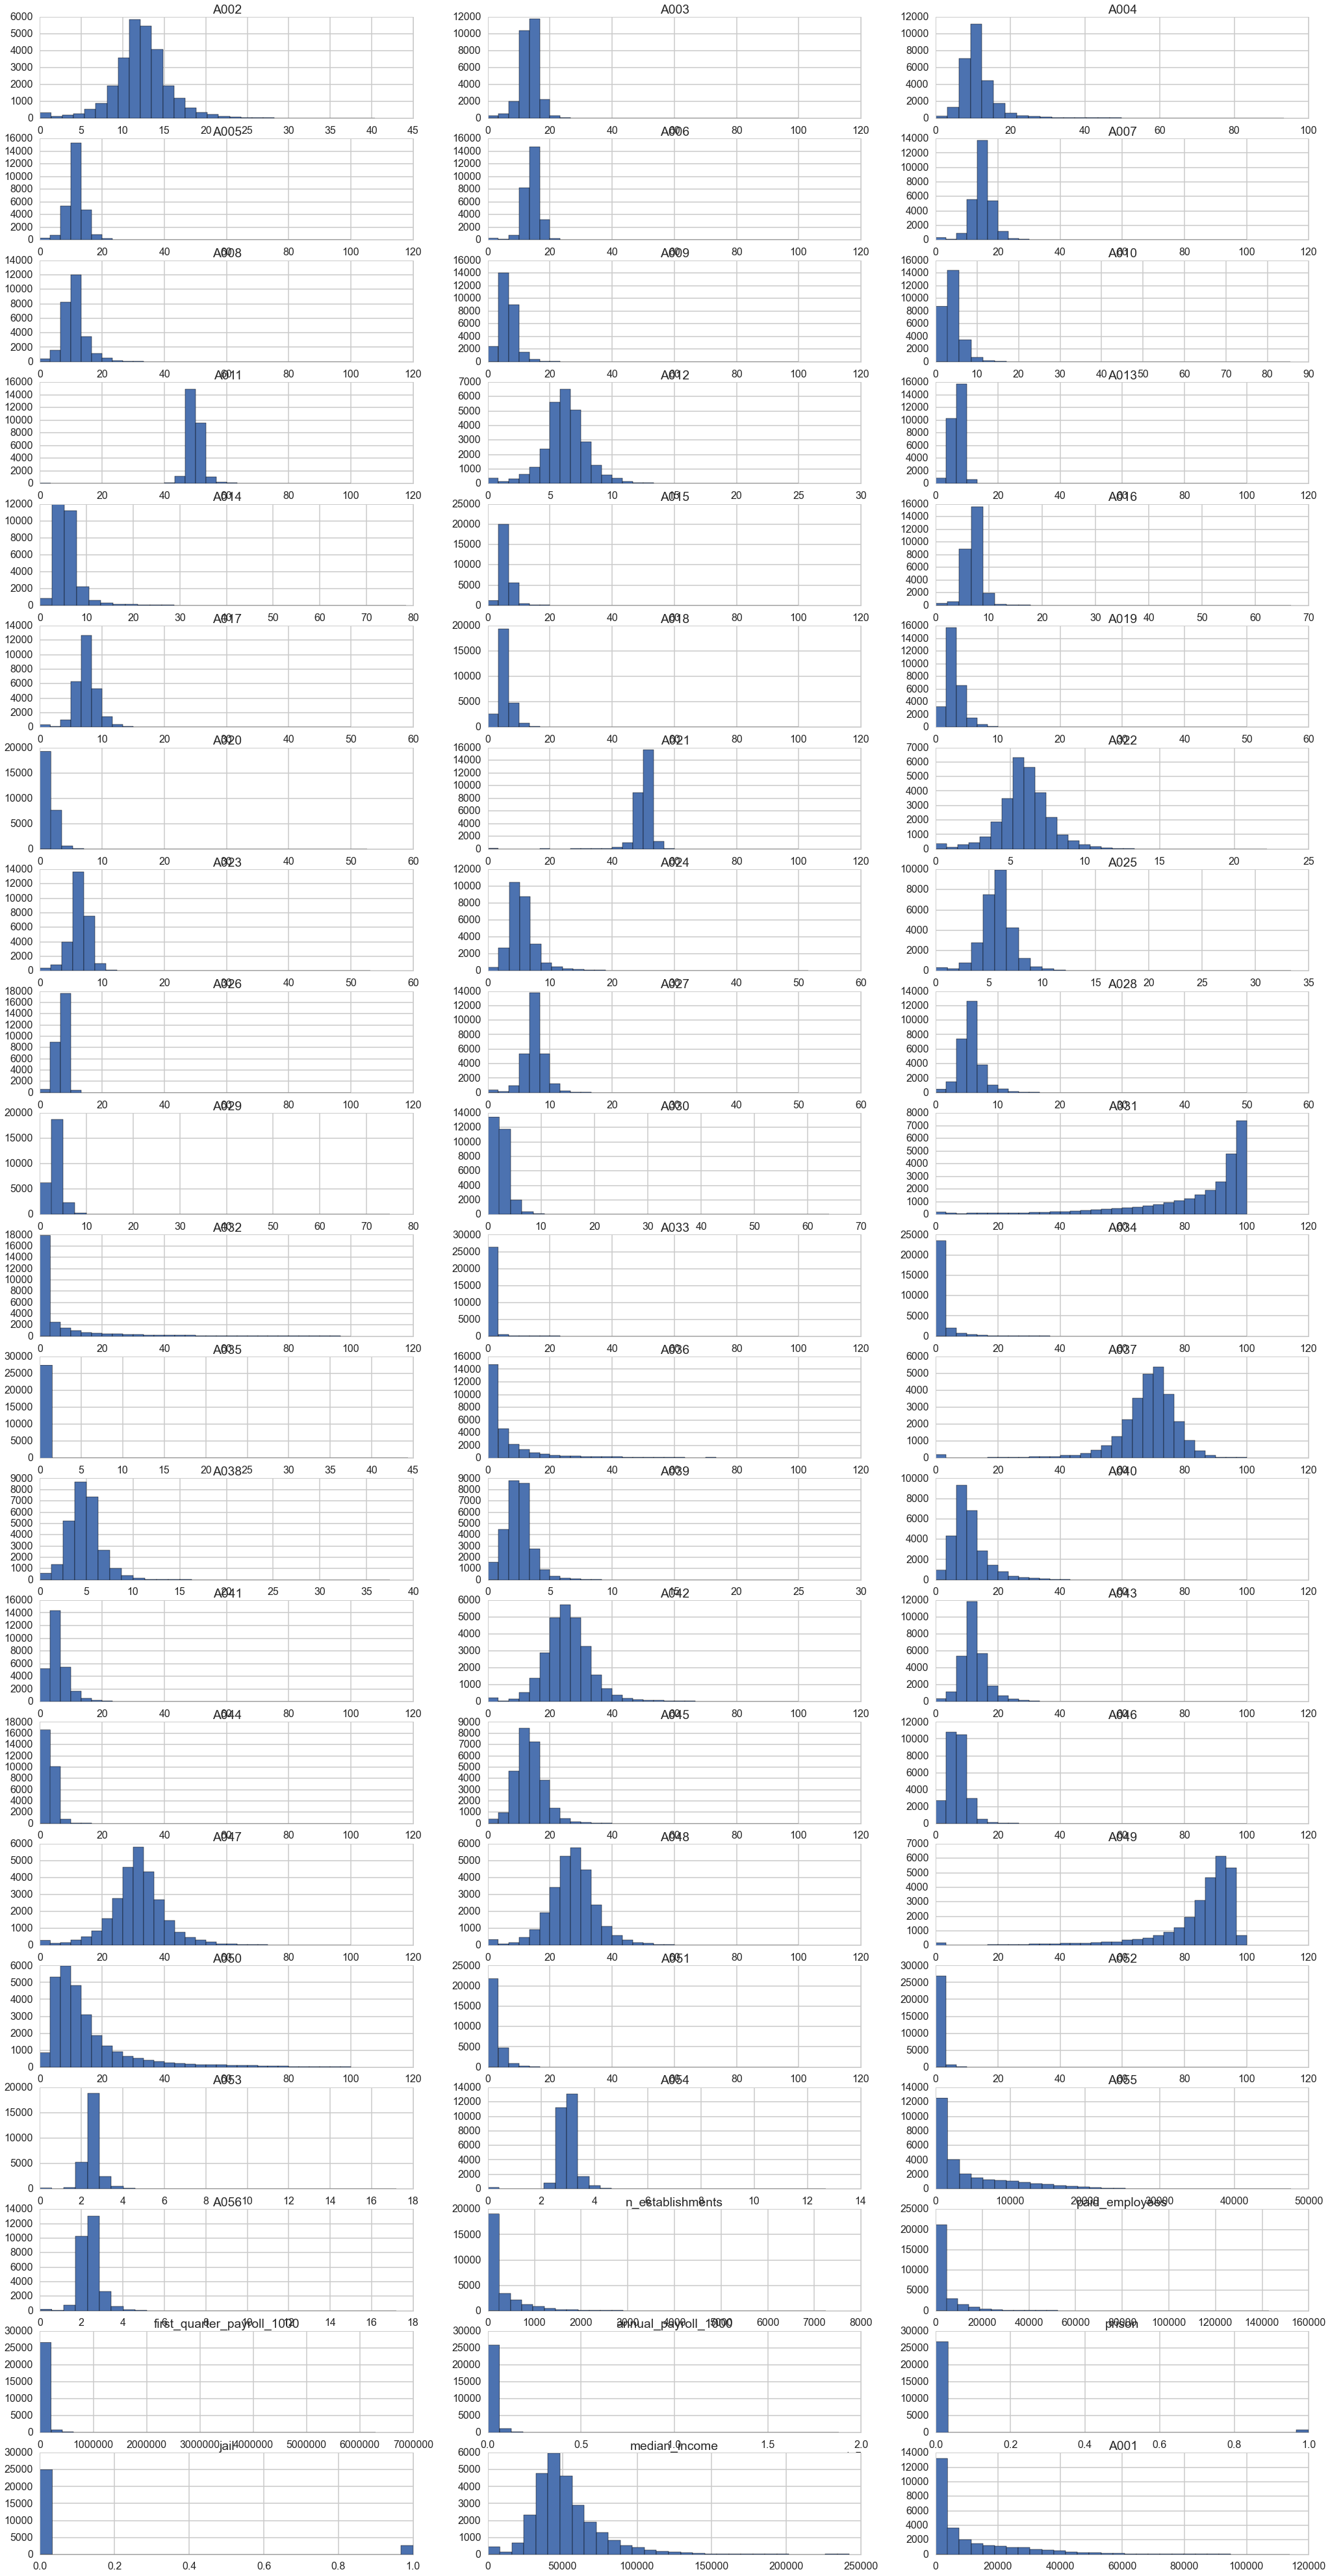

In [58]:
features = all_features.columns[1:]
if len(features)%3 == 0 :
    nROW = len(features)/3
else :
    nROW = np.ceil(len(features)/3.).astype(int)
nCOL = 3

f, ax = plt.subplots(nrows=nROW, ncols=nCOL, figsize=(35,70))

for i in xrange(len(features)):
    plt.subplot(nROW,nCOL,i)
    ax = all_features[features[i]].hist(bins = 30)
    ax.set_title(features[i])

From this, we observe that the following data need transforming:
    
####Right skewed: 
A01, A20, A30, A32, A36, A34, A50, A51, A55, n_establishments, paid_employees  
####Left skewed: 
A31, A49

In [60]:
from sklearn.cross_validation import train_test_split
# split into training and test sets
itrain, itest = train_test_split(xrange(all_features.shape[0]), train_size=0.8)

mask=np.ones(all_features.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

print 'samples in training set = %s \nsamples in test set = %s'%(mask.sum(), mask.shape[0] - mask.sum())

samples in training set = 22122 
samples in test set = 5531


####Here we standardize all features except binary ones, without transforming.

In [61]:
from sklearn.preprocessing import StandardScaler

all_features_stand = all_features.copy()

# standardize all but binary features (i.e indicator variables)
stand_columns = all_features.columns[1:-3].values.tolist() + [all_features.columns[-1]]

train_raw = all_features[mask]

# initialize standardizer on training set
standardizer = StandardScaler().fit(train_raw[stand_columns])
# standardize all data
stand_data = pd.DataFrame(columns=stand_columns, data=standardizer.transform(all_features[stand_columns]))

# drop old non-standardized columns from dataframe
for col in stand_columns:
    all_features_stand = all_features_stand.drop(col, 1)

# merge dftouse with new df that has standardized data
all_features_stand = all_features_stand.merge(stand_data, how='outer', left_index=True, right_index=True)
all_features_stand['zipcode'] = zipCodeStrings

In [62]:
all_features_stand[mask].to_pickle('data/train_all_features_norm.pkl')
all_features_stand[~mask].to_pickle('data/test_all_features_norm.pkl')

#### Standardize all the features except binary ones, WITH transforming.

In [67]:
# *** I didn't exponentiate the right-skeed columns, but that would be easy enough to try
all_features_stand_trans = all_features.copy()

left_skewed_columns = ['A001', 'A020', 'A030', 'A032', 'A036', 'A034', 'A050', 'A051', 'A055', 'n_establishments', 'paid_employees']
right_skewed_columns = ['A31', 'A49']

# log transform all left_skewed columns (np.log1p does natural log of 1 plus input: ln(1 + x)) this avoids
# getting negative infinity when x = 0
log_features = all_features_stand_trans[left_skewed_columns].values.T

for i in xrange(log_features.shape[0]):
    log_features[i] =  np.log1p(log_features[i])
    
log_features_df = pd.DataFrame(log_features.T, columns = left_skewed_columns)

# drop left-skewed columns from dataframe
for col in left_skewed_columns:
    all_features_stand_trans = all_features_stand_trans.drop(col, 1)
    
# merge with new df that has log of left-skewed data
all_features_stand_trans = all_features_stand_trans.merge(log_features_df, how='outer', left_index=True, right_index=True)

# standardize all but binary features (i.e indicator variables)
stand_columns = all_features.columns[1:-3].values.tolist() + [all_features.columns[-1]]

train_raw = all_features_stand_trans[mask]

# initialize standardizer on training set
standardizer = StandardScaler().fit(train_raw[stand_columns])
# standardize all data
stand_data = pd.DataFrame(columns=stand_columns, data=standardizer.transform(all_features_stand_trans[stand_columns]))

# drop old non-standardized columns from dataframe
for col in stand_columns:
    all_features_stand_trans = all_features_stand_trans.drop(col, 1)

# merge dftouse with new df that has standardized data
all_features_stand_trans = all_features_stand_trans.merge(stand_data, how='outer', left_index=True, right_index=True)
all_features_stand_trans['zipcode'] = zipCodeStrings

In [68]:
all_features_stand_trans[mask].to_pickle('data/train_all_features_norm_and_transform.pkl')
all_features_stand_trans[~mask].to_pickle('data/test_all_features_norm_and_transform.pkl')

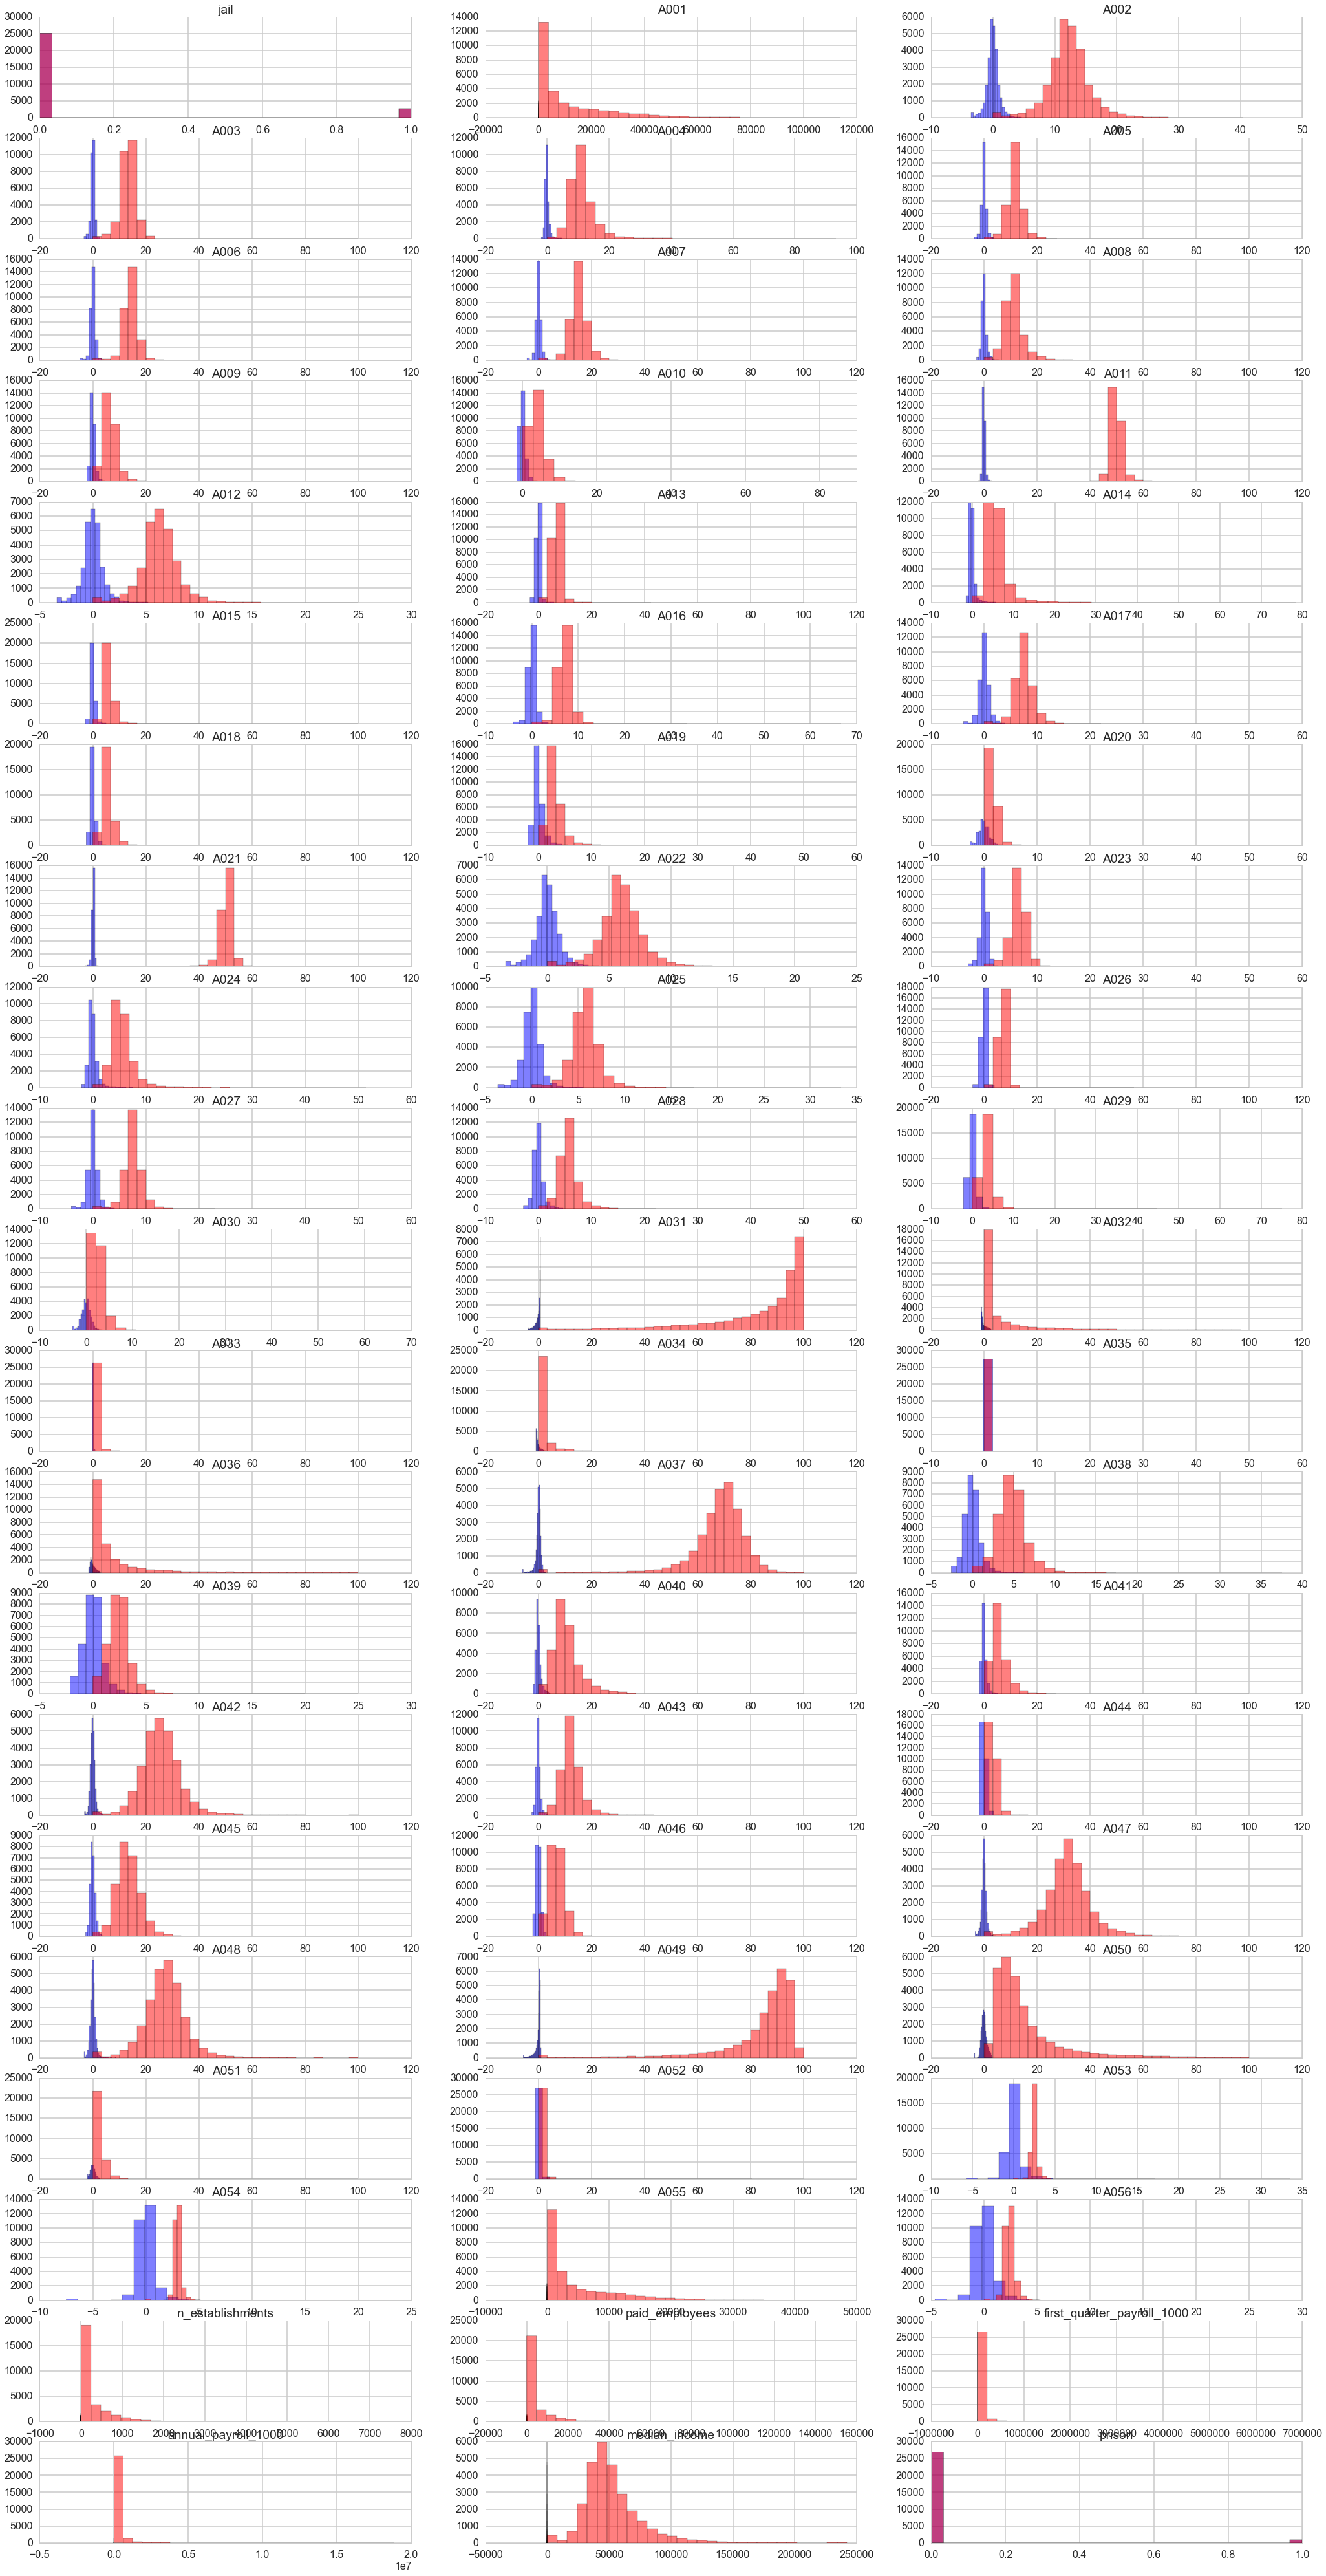

In [69]:
features_st = all_features_stand_trans.columns[1:]
if len(features_st)%3 == 0 :
    nROW = len(features_st)/3
else :
    nROW = np.ceil(len(features_st)/3.).astype(int)
nCOL = 3

f, ax = plt.subplots(nrows=nROW, ncols=nCOL, figsize=(35,70), sharex=False)

for i in xrange(len(features_st)):
    plt.subplot(nROW,nCOL,i)
    ax = all_features_stand_trans[features_st[i]].hist(bins = 30, color='b', alpha=.5)
    # uncomment line below to see old features (red) vs. new (blue)
    all_features[features_st[i]].hist(bins = 30, color='r', alpha=.5)
    ax.set_title(features_st[i])